In [1]:
using RxInfer, Plots, StableRNGs, Distributions, ExponentialFamily, LinearAlgebra
import ExponentialFamily: softmax 


ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [2]:
function generate_multinomial_data(rng=StableRNG(123);N = 20, k=9, nsamples = 1000)
    Ψ = randn(rng, k)
    p = softmax(Ψ)
    X = rand(rng, Multinomial(N, p), nsamples)
    X= [X[:,i] for i in 1:size(X,2)];
    return X, Ψ,p
end

generate_multinomial_data (generic function with 2 methods)

In [3]:
nsamples = 5000
N = 20
K = 20
X, Ψ, p = generate_multinomial_data(nsamples=nsamples, N=N, k=K);

In [4]:
@model function multinomial_model(obs, N, ξ_ψ, W_ψ)
    ψ ~ MvNormalWeightedMeanPrecision(ξ_ψ, W_ψ)
    obs .~ MultinomialPolya(N, ψ) where {dependencies = RequireMessageFunctionalDependencies(ψ = MvNormalWeightedMeanPrecision(ξ_ψ, W_ψ))}
end

In [5]:
result = infer(
    model = multinomial_model(ξ_ψ=zeros(K-1), W_ψ=rand(Wishart(K-1, diageye(K-1))), N=N),
    data = (obs=X, ),
    iterations = 20,
    free_energy = true,
    showprogress = true,
    options = (
        limit_stack_depth = 100,
    )
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Inference results:
  Posteriors       | available for (ψ)
  Free Energy:     | Real[164595.0, 1.22061e5, 1.07914e5, 1.01651e5, 98436.7, 96629.6, 95548.5, 94872.0, 94433.8, 94142.3, 93944.0, 93806.7, 93710.2, 93641.3, 93591.8, 93555.7, 93529.2, 93509.6, 93495.1, 93484.2]


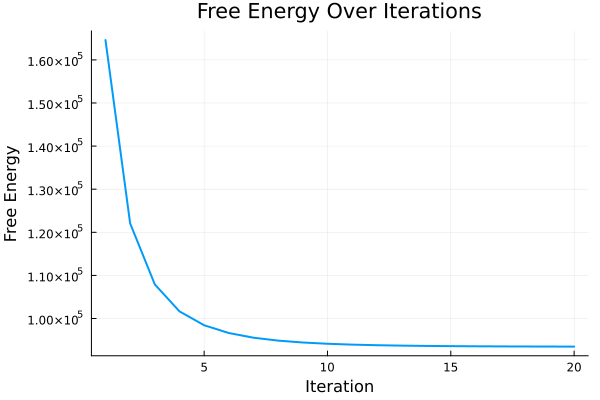

In [6]:
plot(result.free_energy, 
     title="Free Energy Over Iterations",
     xlabel="Iteration",
     ylabel="Free Energy",
     linewidth=2,
     legend=false,
     grid=true,
     )

In [7]:
predictive = @call_rule MultinomialPolya(:x, Marginalisation) (q_N = PointMass(N), q_ψ = result.posteriors[:ψ][end])

Multinomial{Float64, Vector{Float64}}(
n: 20
p: [0.029158072884442162, 0.06474598903703664, 0.012407200928015658, 0.030050182075660004, 0.031049748237837536, 0.08770451452781097, 0.018292251895544363, 0.015803300391201196, 0.014277044646571325, 0.009750301717203218, 0.013527116528436795, 0.009811209740447519, 0.010667810854460157, 0.08479802733531325, 0.24893083196363822, 0.16284615105342162, 0.05987204193507125, 0.05462065287848993, 0.022191036280669277, 0.01949651508872873]
)


In [8]:
mse = mean((predictive.p - p).^2);
println("predictive MSE: $mse")

predictive MSE: 4.5814593172795105e-6


In [15]:
@model function multinomial_regression(obs, N, X, ϕ, ξβ, Wβ)
    β ~ MvNormalWeightedMeanPrecision(ξβ, Wβ)
    for i in eachindex(obs)
        Ψ[i] := ϕ(X[i])*β
        obs[i] ~ MultinomialPolya(N, Ψ[i]) where {dependencies = RequireMessageFunctionalDependencies(ψ = MvNormalWeightedMeanPrecision(zeros(length(obs[i])-1), diageye(length(obs[i])-1)))}
    end
end


In [16]:
function generate_regression_data(rng=StableRNG(123);ϕ = identity,N = 3, k=5, nsamples = 1000)
    β = randn(rng, k)
    X = randn(rng, nsamples, k, k)
    X = [X[i,:,:] for i in 1:size(X,1)];
    Ψ = ϕ.(X)
    p = map(x -> logistic_stick_breaking(x*β), Ψ)
    return map(x -> rand(rng, Multinomial(N, x)), p), X, β, p
end


generate_regression_data (generic function with 2 methods)

In [17]:
ϕ = x -> sin(x)
obs, X, β, p = generate_regression_data(;nsamples = 5000, ϕ = ϕ);

In [24]:
reg_results = infer(  
    model = multinomial_regression(N = 3, ϕ = ϕ, ξβ = zeros(5), Wβ = rand(Wishart(5, diageye(5)))),
    data = (obs=obs,X = X ),
    iterations = 10,
    free_energy = true,
    showprogress = true,
    returnvars = KeepLast(),
    options = (
        limit_stack_depth = 100,
    ) 
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Inference results:
  Posteriors       | available for (Ψ, β)
  Free Energy:     | Real[11953.5, 11587.9, 11505.8, 11484.9, 11479.3, 11477.7, 11477.3, 11477.1, 11477.1, 11477.1]


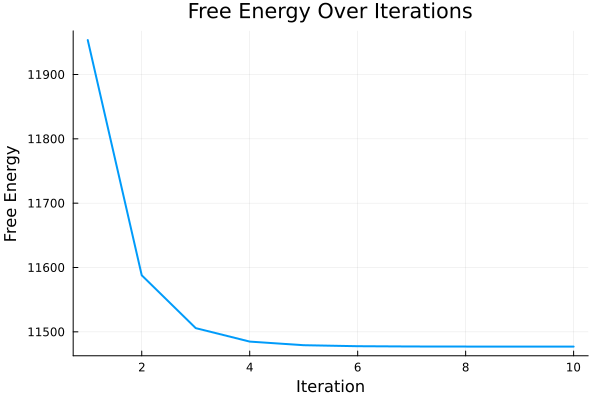

In [25]:
plot(reg_results.free_energy,
title="Free Energy Over Iterations",
xlabel="Iteration",
ylabel="Free Energy",
linewidth=2,
legend=false,
grid=true,)

In [26]:
mse_β =  mean((mean(reg_results.posteriors[:β]) - β).^2)
println("MSE of β estimate: $mse_β")

MSE of β estimate: 8.074365848145953e-5


In [27]:
@model function gp_multinomial_regression(y, P, A, Q, var_noise, N)
    H ~ MvNormal(μ = zeros(3), Σ = diageye(3))
    f_prev ~ MvNormal(μ = zeros(length(H)), Σ = P) #initial state
    w ~ GammaShapeRate(1.0, 1.0)
    for i in eachindex(y)
        f[i] ~ MvNormal(μ = A[i] * f_prev,Σ = Q[i])
        z[i] ~ softdot(H , f[i], w) where
        y[i] ~ MultinomialPolya(N, z[i])
        f_prev = f[i]
    end
end

In [ ]:
θ = [1.0, 1.0];
n = 100;
t = collect(range(-2, 2, length=n)); #timeline
Δt = [t[1]]; # time difference
append!(Δt, t[2:end] - t[1:end-1]);
λ = sqrt(5)/θ[1];
#### compute matrices for the state-space model ######
L = [0., 0., 1.];
H = [0.1, 0.1, 0.1];
F = [0. 1. 0.; 0. 0. 1.;-λ^3 -3λ^2 -3λ]
Qc = 16/3 * θ[2] * λ^5;

I = diageye(3) ; 
vec_P = inv(kron(I,F) + kron(F,I)) * vec(-L * Qc * L'); 
P∞ = reshape(vec_P,3,3);
A = [exp(F * i) for i in Δt]; 
Q = [P∞ - i*P∞*i' for i in A];